In [21]:
import networkx as nx
from uccgGenerator import tree_insertion
import random
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout
from networkx.algorithms.approximation.treewidth import *
from networkx.algorithms.dag import *
from copy import deepcopy

ModuleNotFoundError: No module named 'dwave_networkx'

In [23]:
res = 'res'
sep = 'sep'
label = 'I'
status = 'status'
I_edge = 'I_edge'
F_edge = 'F_edge'
common_edge = 'common_edge'
in_current = 'in_current'

connectionstyle = 'arc3, rad=0.1'
node_size = 300
color = 'white'
font_size = 13
alpha=1
width = 2

In [24]:
def get_IF(I, F):
    common_edges = list(set(I.edges).intersection(F.edges))
    diff_edges = list(set(I.edges).symmetric_difference(F.edges))
    IF = nx.DiGraph()

    IF.add_edges_from(common_edges+diff_edges)
    for e in set(I.edges) - set(F.edges):
        IF.edges[e][label] = I_edge
        IF.edges[e][in_current] = True 
    for e in set(F.edges) - set(I.edges):
        IF.edges[e][label] = F_edge 
        IF.edges[e][in_current] = False
    for e in common_edges:
        IF.edges[e][label] = common_edge 
        IF.edges[e][in_current] = True 
    return IF

In [25]:
def current_graph(IF):
    current_edges = [e for e in IF.edges if IF.edges[e][in_current]]
    dg = nx.DiGraph()
    dg.add_edges_from(current_edges)
    return dg

In [26]:
def plot_edges(IF, pos, edges):
    if len(edges) == 0:
        return
    e = edges[0]
    is_in_current = IF.edges[e][in_current]
    color = {I_edge: 'b', F_edge: 'r'}[IF.edges[e][label]]
    width = {True: 1.5, False: 1}[is_in_current]
    alpha = {True:1, False:0.5}[is_in_current]
    nx.draw_networkx_edges(IF, pos, edges, edge_color=color, alpha=alpha, width=width, connectionstyle=connectionstyle)

In [8]:
def plot_IF(IF, pos):
    nx.draw_networkx_nodes(IF, pos, linewidths=width, node_size=node_size, node_color=color, edgecolors='k')
    nx.draw_networkx_edges(IF, pos, [e for e in IF.edges if IF.edges[e][label] == common_edge], width=1, alpha=0.3)
    I_edges = [e for e in IF.edges if IF.edges[e][label] == I_edge]
    F_edges = [e for e in IF.edges if IF.edges[e][label] == F_edge]
     
    plot_edges(IF, pos, [e for e in I_edges if IF.edges[e][in_current]])
    plot_edges(IF, pos, [e for e in I_edges if not IF.edges[e][in_current]])
    plot_edges(IF, pos, [e for e in F_edges if IF.edges[e][in_current]])
    plot_edges(IF, pos, [e for e in F_edges if not IF.edges[e][in_current]])
    nx.draw_networkx_labels(IF, pos)
    a = 3

In [9]:
def plot_complement(IF, pos):
    common_edges = [e for e in IF.edges if IF.edges[e][label] == common_edge]
    complement_edges = [e for e in IF.edges if IF.edges[e][label] != common_edge and not IF.edges[e][in_current]]
#     current_edges = [e for e in IF.edges if IF.edges[e][in_current] and IF.edges[e][label] != common_edge]
    nx.draw_networkx_edges(IF, pos, common_edges, edge_color='k', width=1, alpha=1)
    nx.draw_networkx_edges(IF, pos, complement_edges, edge_color='m', width=1.5
#                            , connectionstyle=connectionstyle
                          )
#     nx.draw_networkx_edges(IF, pos, current_edges, edge_color='g', alpha=0.5, width=1, connectionstyle=connectionstyle)
    nx.draw_networkx_nodes(IF, pos, linewidths=width, node_size=node_size, node_color=color, edgecolors='k')
    nx.draw_networkx_labels(IF, pos)

In [10]:
def get_sep_and_res(rt, u):
    predecessors = set(rt.predecessors(u))
    parent = list(predecessors)[0] if len(predecessors) > 0 else None
    rt.nodes[u][sep] = u.intersection(parent) if parent else set()
    rt.nodes[u][res] = u - rt.nodes[u][sep]
    for v in rt.successors(u):
        get_sep_and_res(rt, v)

In [11]:
def flippable(IF, u, v):
    for w in IF.neighbors(u):
        if IF.edges[(u, w)][in_current] and (w, v) in IF.edges and IF.edges[(w, v)][in_current]:
            return False
    return True

In [12]:
def get_flippable_edges(IF, root):
    return [e for e in IF.subgraph(root).edges if IF.edges[e][in_current] and IF.edges[e][label] == I_edge and flippable(IF, *e)]

In [13]:
def plot_rt(g, cycles=None):
    plt.axis('off')
    pos = graphviz_layout(rt, prog='dot')
    nx.draw_networkx_edges(g, pos, width=2)
    node_size = 1000
    color = 'white'
    font_size = 13
    alpha=1
    width = 2
    if not cycles:
        nx.draw_networkx_nodes(g, pos, linewidths=width, node_size=node_size, alpha=alpha, node_color=color, edgecolors='k', node_shape='s')
    else:
        node_contain_cycles = [u for u in g for c in cycles if c.issubset(u)]
        nx.draw_networkx_nodes(g, pos, nodelist=node_contain_cycles, linewidths=width, node_size=node_size, alpha=alpha, node_color=color, edgecolors='r', node_shape='s')
        nx.draw_networkx_nodes(g, pos, nodelist=g.nodes-set(node_contain_cycles), linewidths=width, node_size=node_size, alpha=alpha, node_color=color, edgecolors='k', node_shape='s')
        
    labels = {u: ','.join(map(str, list(u))) for u in g}
    nx.draw_networkx_labels(g, pos, labels, font_size=font_size)

In [14]:
def process_clique(IF, pos, root, rt, plot=False):
    edges = get_flippable_edges(IF, root)
    while edges:
        u, v = edges[0]
        IF.edges[(u, v)][in_current] = False
        IF.edges[(v, u)][in_current] = True
        if plot:
            plt.figure(figsize=(18, 6))
            plt.subplot(1,3,1)
            plt.title(f'{root}, reverse {(u, v)}')
            plot_IF(IF, pos)
            plt.subplot(1,3,2)
            dg = nx.DiGraph()
            dg.add_edges_from([e for e in IF.edges if not IF.edges[e][in_current] or IF.edges[e][label]==common_edge])
            cycles = [set(c) for c in nx.simple_cycles(dg) if len(c)==3]
            plt.title(f"{cycles}")
            plot_complement(IF, pos)
            plt.subplot(1,3,3)
            plot_rt(rt, cycles)
        edges = get_flippable_edges(IF, root)
        if not nx.is_directed_acyclic_graph(current_graph(IF)):
            raise Exception

In [15]:
def succeed(IF):
    untouched_I = [e for e in IF_copy.edges if IF_copy.edges[e][in_current] and IF_copy.edges[e][label]==I_edge]
    untouched_F = [e for e in IF_copy.edges if not IF_copy.edges[e][in_current] and IF_copy.edges[e][label]==F_edge]
    return not untouched_I and not untouched_F

In [16]:
def process(IF, pos, rt, root, plot=False):
    children = list(rt.successors(root))
    process_clique(IF, pos, root, rt, plot)
    if children:
        for child in children:
            process(IF, pos, rt, child, plot)
        process_clique(IF, pos, root, rt, plot)

In [17]:
def resample(g, cycles):
    edges_to_resample = set()
    for a, b, c in cycles:
        edges_to_resample.update([(a, b), (b, c), (c, a)])
    for x, y in edges_to_resample:
        flag = random.randint(0, 1)
        if flag == 0:
            continue
        g.remove_edge(x, y)
        g.add_edge(y, x)

In [18]:
def gen_random_acyclic_orientation(g):
    dg = nx.DiGraph()
    for u, v in g.edges:
        coin = random.randint(0, 1)
        if coin == 0:
            dg.add_edge(u, v)
        else:
            dg.add_edge(v, u)
    while not is_directed_acyclic_graph(dg):
        cycles = [c for c in nx.simple_cycles(dg) if len(c)==3]
        resample(dg, cycles)
    return dg

In [20]:
nx.algorithms.chordal.chordal_graph_cliques(g)

NameError: name 'g' is not defined

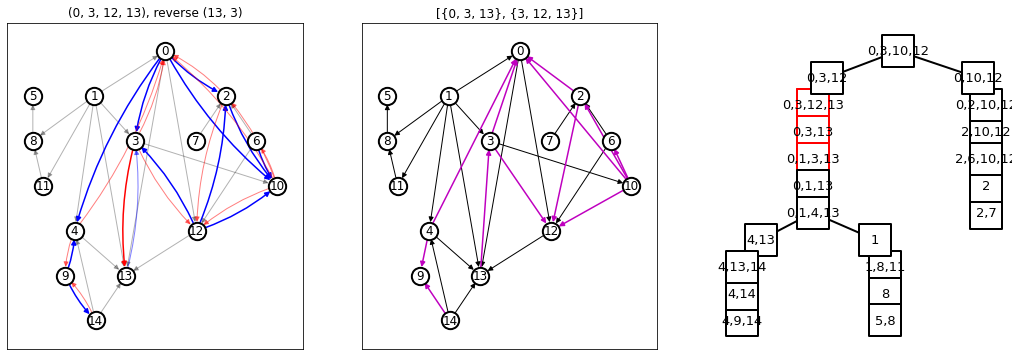

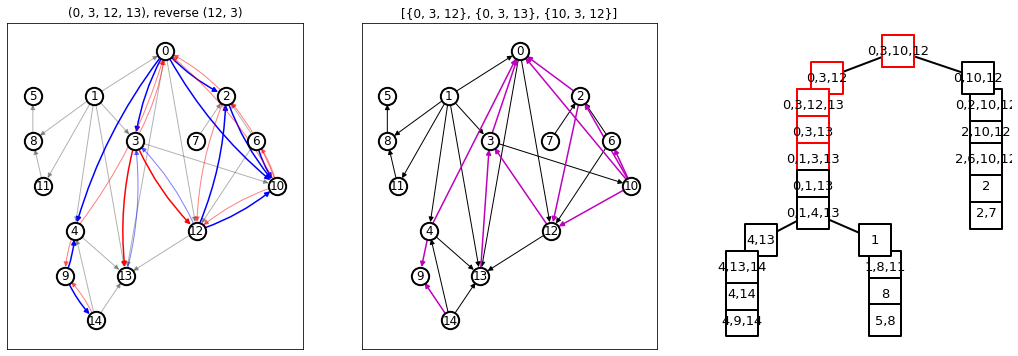

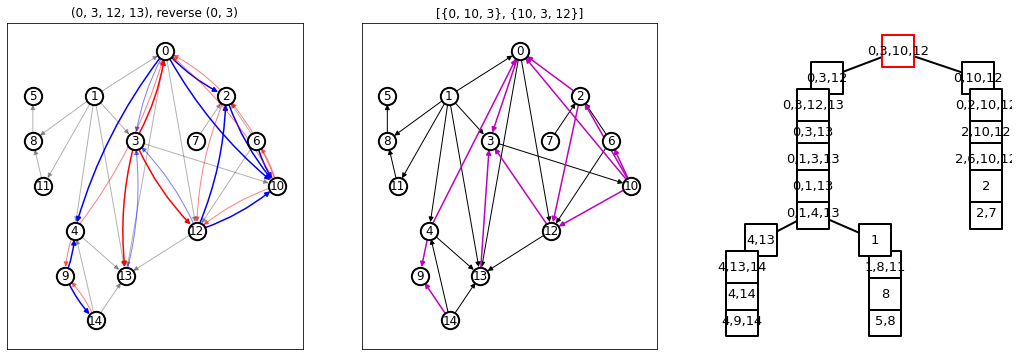

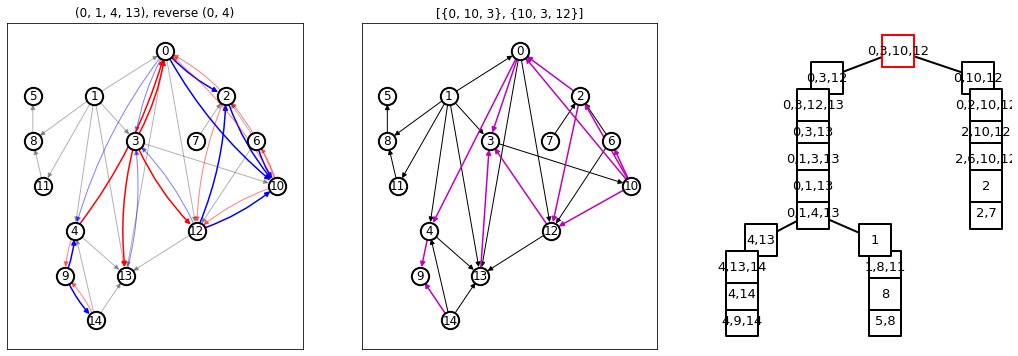

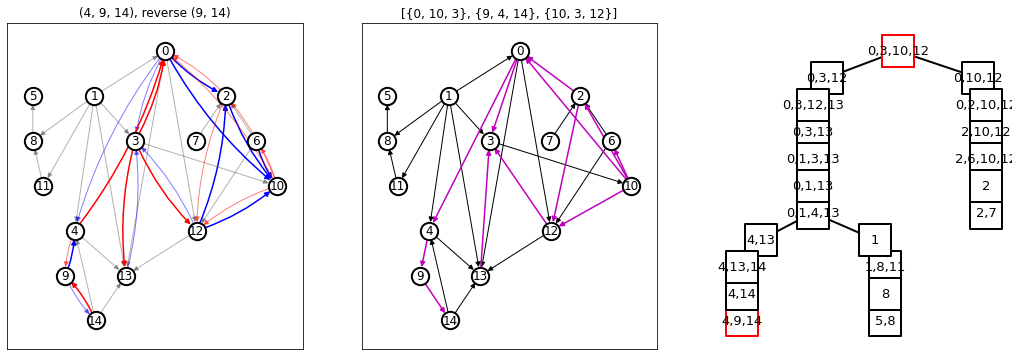

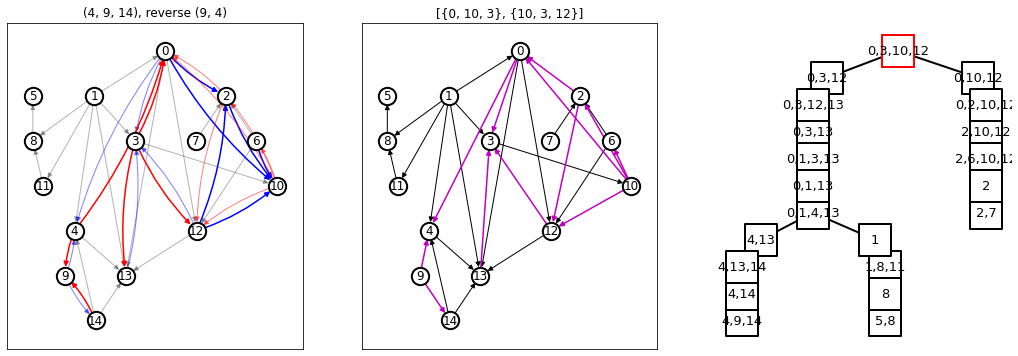

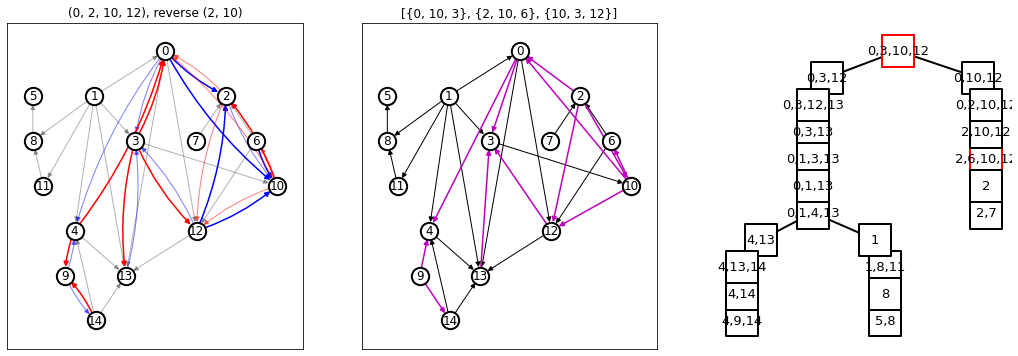

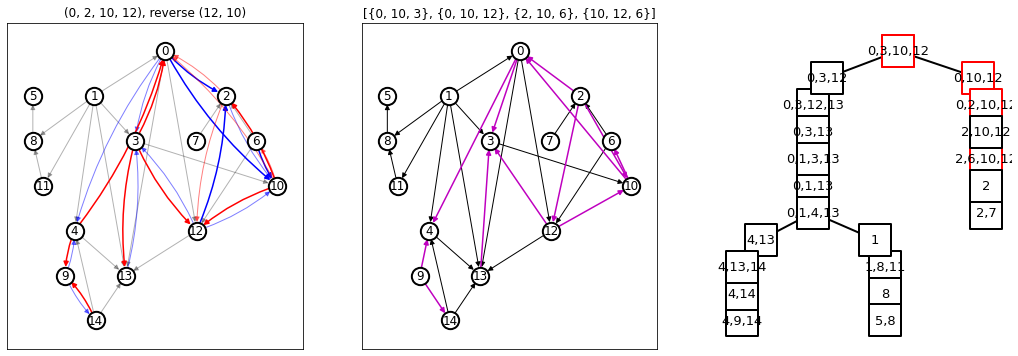

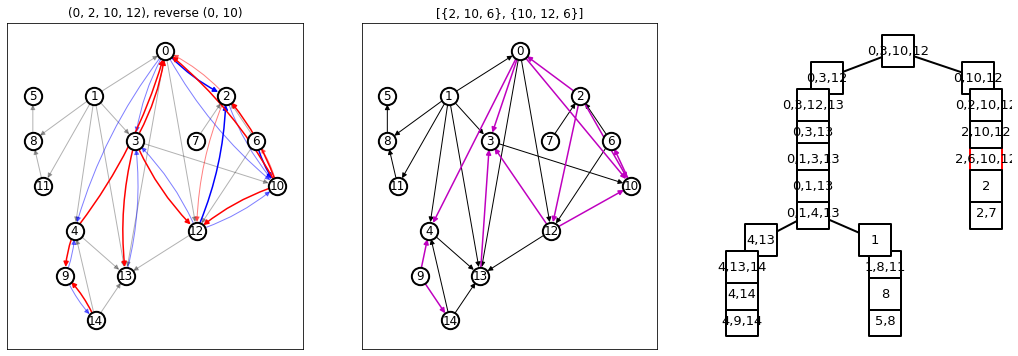

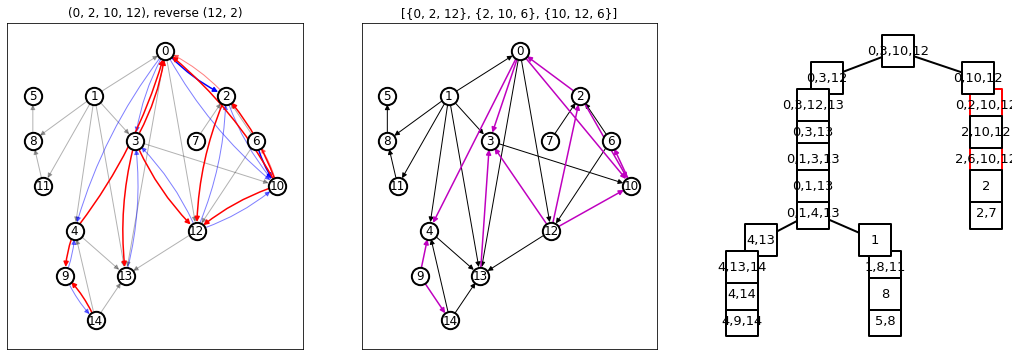

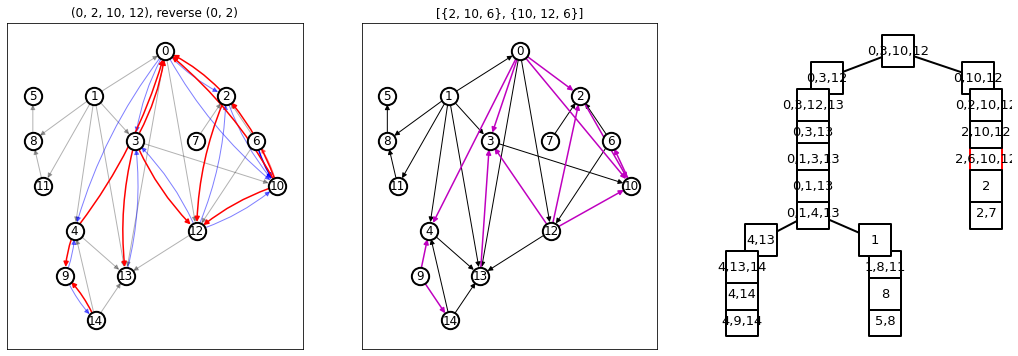

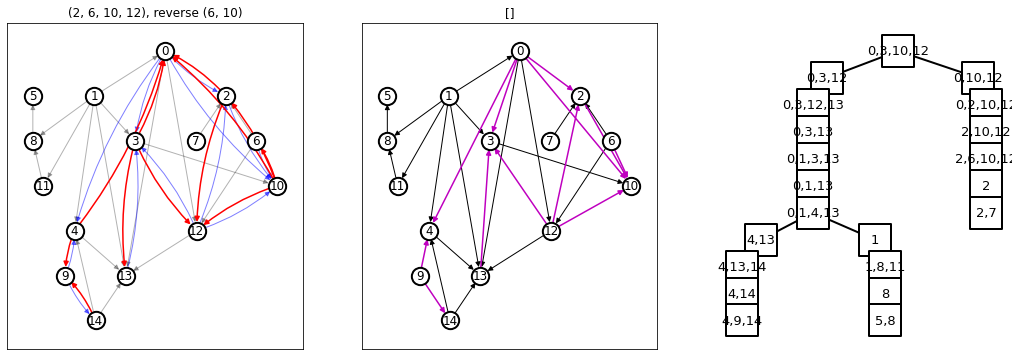

In [96]:
n, m = 15, 30
for i in range(1):
    g = tree_insertion(n, m)
    I = gen_random_acyclic_orientation(g)
    F = gen_random_acyclic_orientation(g)
    IF = get_IF(I, F)
    pos = graphviz_layout(g, prog='dot')

    t = nx.algorithms.tree.decomposition.junction_tree(g)
    cliques = nx.algorithms.chordal.chordal_graph_cliques(g)
    root = random.choice([c for c in t if frozenset(c) in cliques])
    rt = nx.dfs_tree(t, root)
    IF_copy = nx.DiGraph(IF)
    process(IF_copy, pos, rt, root, plot=True)
    IF_initial = deepcopy(IF)
    if not succeed(IF_copy):
        nx.write_edgelist(I, path=f"I_node_{n}_{i}.edgelist", delimiter=":")
        nx.write_edgelist(F, path=f"F_node_{n}_{i}.edgelist", delimiter=":")
        IF_copy = nx.DiGraph(IF)
        process(IF_copy, pos, rt, root, plot=True)
        break

In [97]:
succeed(IF_copy)

True

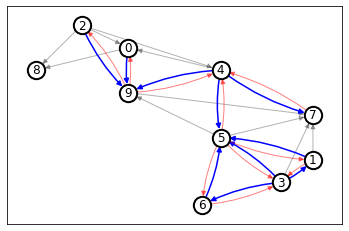

In [40]:
i = 118
I = nx.read_edgelist(path=f"I_node_{n}_{i}.edgelist", delimiter=":", create_using=nx.DiGraph)
F = nx.read_edgelist(path=f"F_node_{n}_{i}.edgelist", delimiter=":", create_using=nx.DiGraph)
IF = get_IF(I, F)
_, t = treewidth_min_fill_in(I.to_undirected())
pos = graphviz_layout(I.to_undirected(), prog='dot')
plot_IF(IF, pos)

In [88]:
t = nx.algorithms.tree.decomposition.junction_tree(I.to_undirected())

In [92]:
rt = nx.dfs_tree(t,(3, 5, 11))
root = (3, 5, 11)

In [93]:
IF_copy = nx.DiGraph(IF)

In [94]:
process(IF_copy, pos, rt, root, plot=False)

In [95]:
succeed(IF_copy)

True

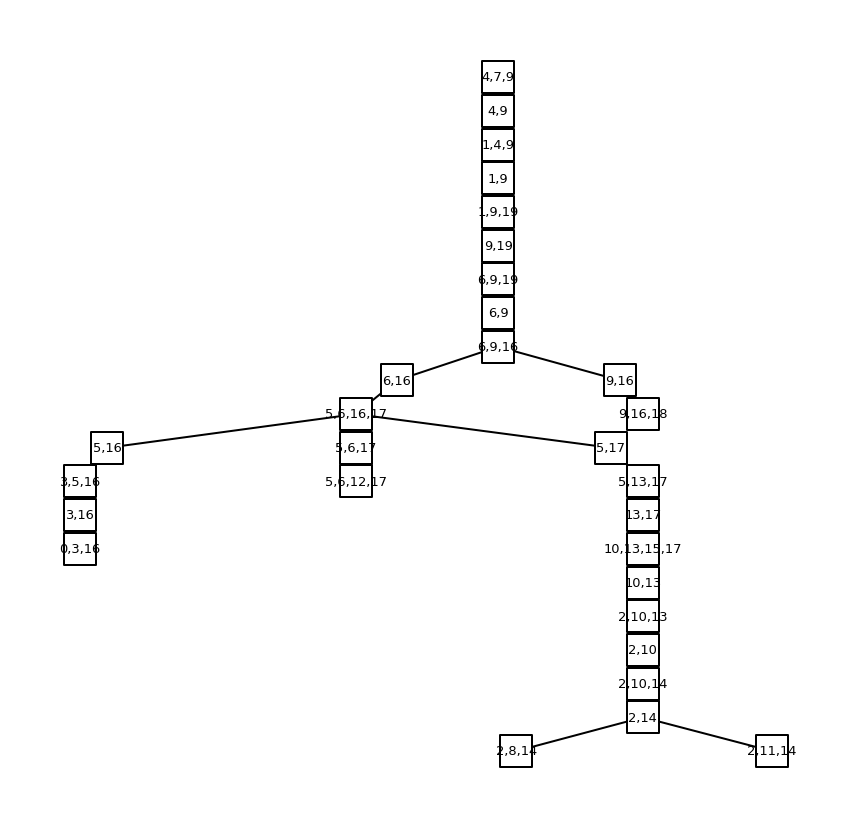

In [81]:
plt.figure(figsize=(15, 15))
plot_rt(rt)

In [55]:
rt = nx.dfs_tree(t, ('1', '3', '5', '7'))

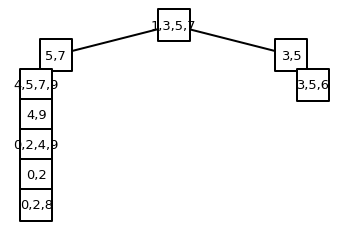

In [56]:
pos = graphviz_layout(rt, prog='dot')
plot_rt(rt)

In [60]:
pos = graphviz_layout(I.to_undirected(), prog='dot')
t = nx.algorithms.tree.decomposition.junction_tree(I.to_undirected())
for root in t:
    print(root)
    rt = nx.dfs_tree(t, root)
    IF_copy = nx.DiGraph(IF)
    process(IF_copy, pos, rt, root, plot=False)
    print(succeed(IF_copy))

('0', '2', '8')
True
('0', '2', '4', '9')
True
('4', '5', '7', '9')
True
('3', '5', '6')
True
('1', '3', '5', '7')
True
('0', '2')
True
('4', '9')
False
('5', '7')
True
('3', '5')
False


In [57]:
root =  ('1', '3', '5', '7')
t = nx.algorithms.tree.decomposition.junction_tree(I.to_undirected())
rt = nx.dfs_tree(t, root)
pos = graphviz_layout(I.to_undirected(), prog='dot')

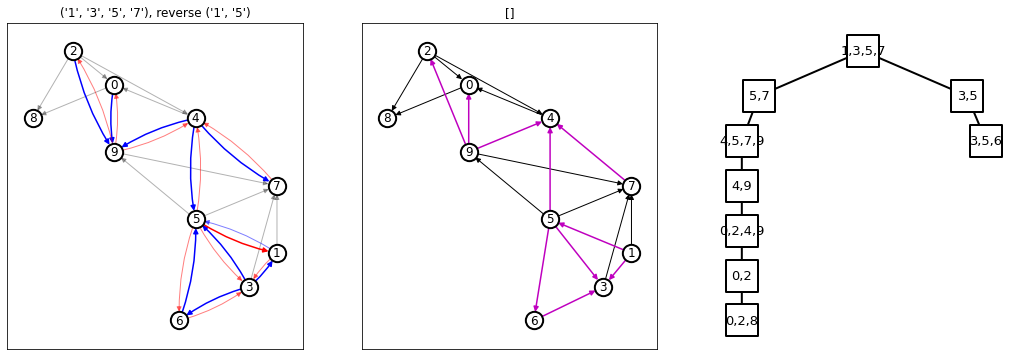

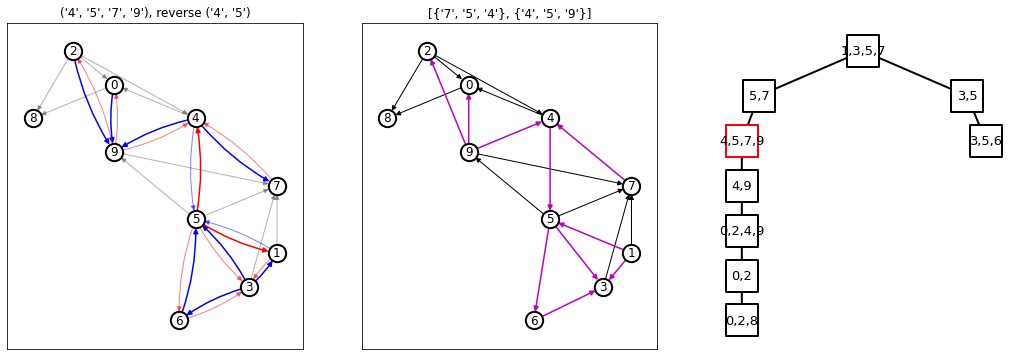

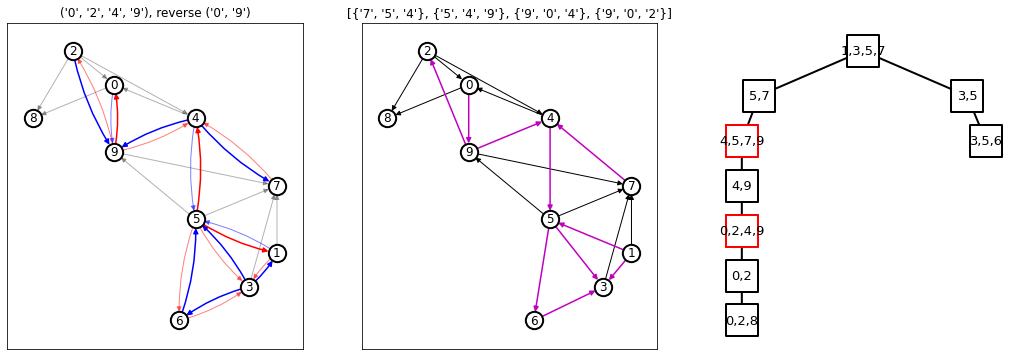

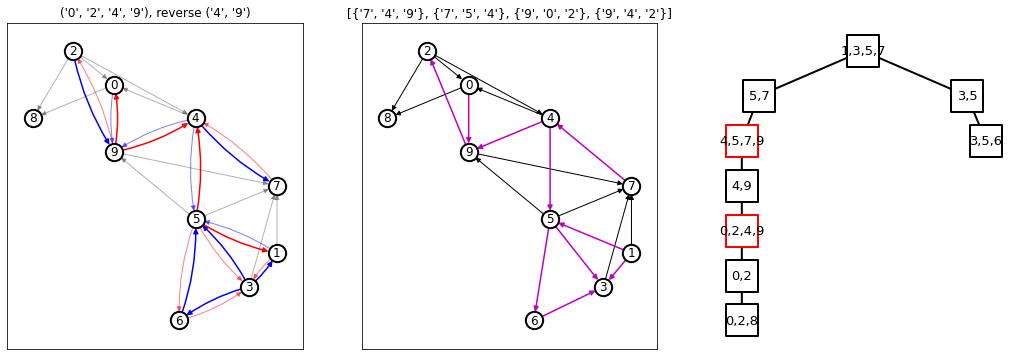

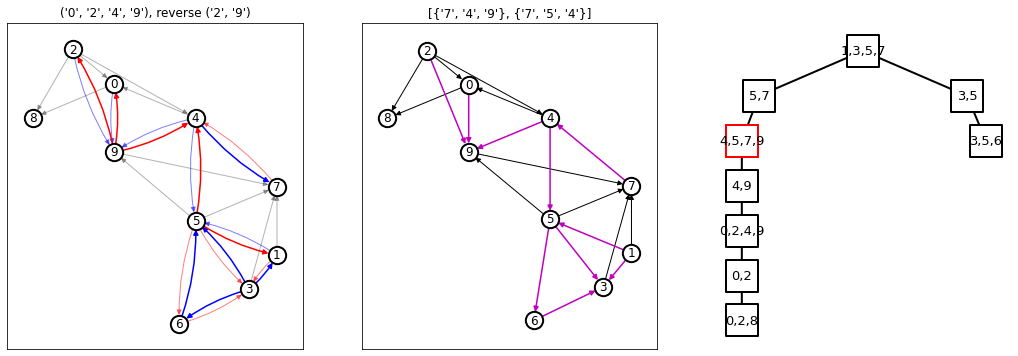

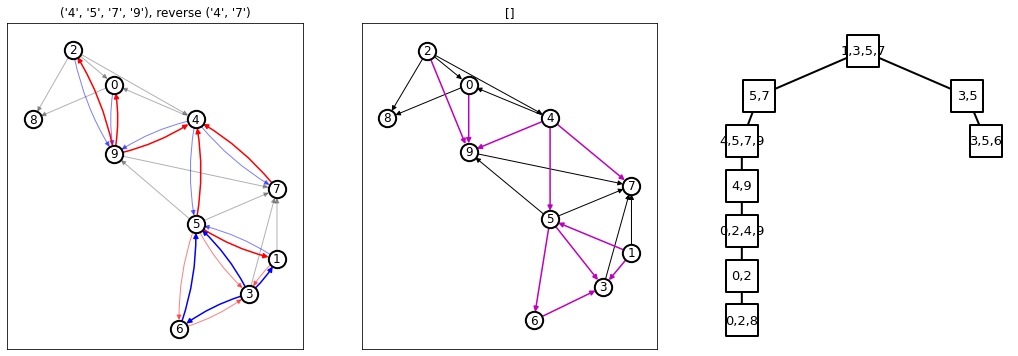

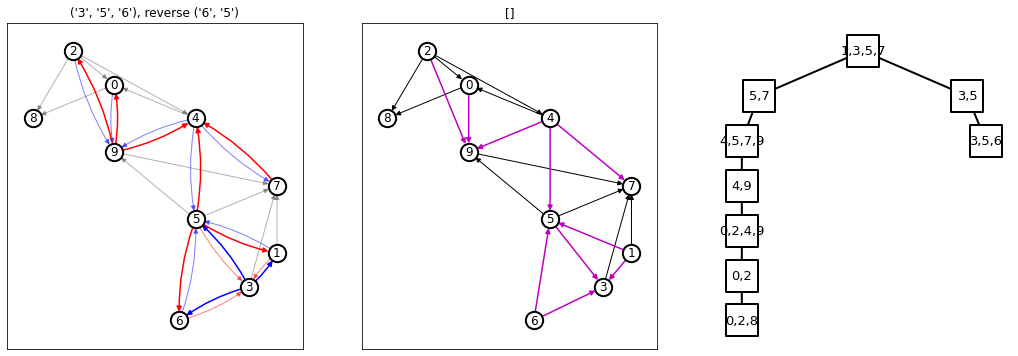

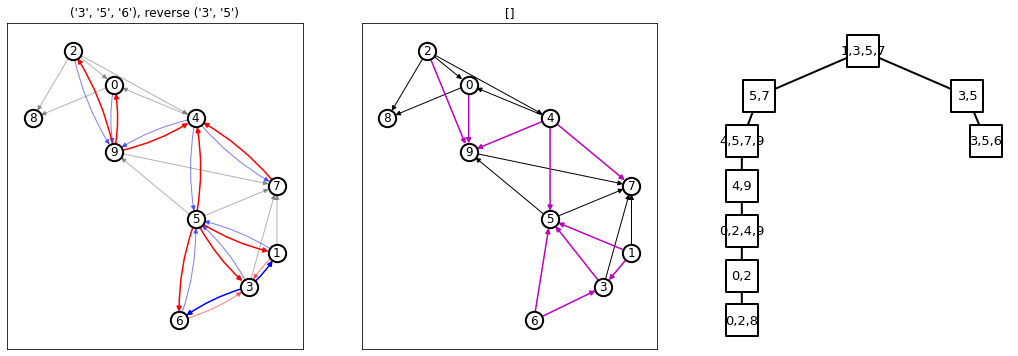

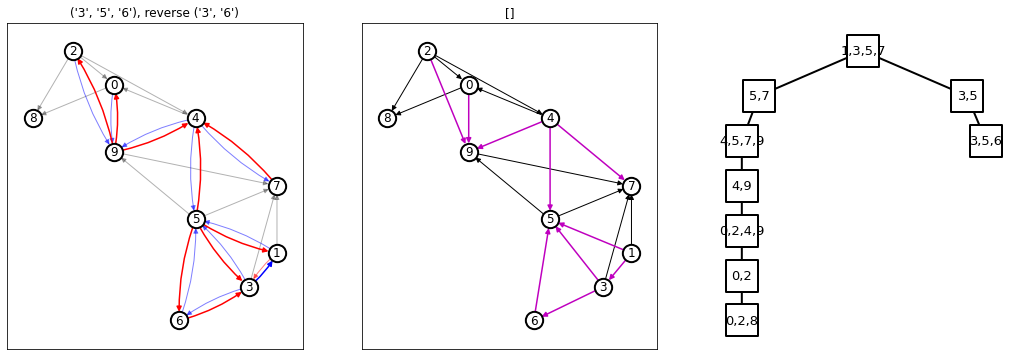

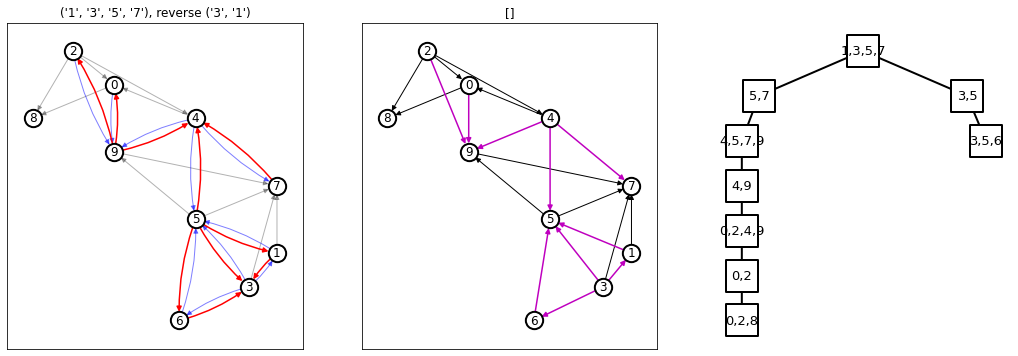

In [58]:
IF_copy = nx.DiGraph(IF)
process(IF_copy, pos, rt, root, plot=True)

In [59]:
succeed(IF_copy)

True